In [15]:
import pandas as pd
import numpy as np
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [16]:
df_train_LOX = pd.read_csv('../data/training_set_LOX.csv')
df_train_ANT = pd.read_csv('../data/training_set_antioxidant.csv')
df_test = pd.read_csv('../data/test_set.csv')

#drop title column
df_train_LOX = df_train_LOX.drop(columns = ['Title'], axis = 1)
df_train_ANT = df_train_ANT.drop(columns = ['Title'], axis = 1)
df_test = df_test.drop(columns = ['Title'], axis = 1)



In [17]:
#replace NaN values in each file with mean of column

mean_values_LOX = df_train_LOX.mean()
mean_values_ANT = df_train_ANT.mean()

df_train_LOX = df_train_LOX.fillna(mean_values_LOX)
df_train_ANT = df_train_ANT.fillna(mean_values_ANT)

#merge LOX and ANT arrays
frames = [df_train_LOX, df_train_ANT]
merged_train = pd.concat(frames)
merged_train.shape


(6196, 278)

Shape of train set after column drop (6196, 159)


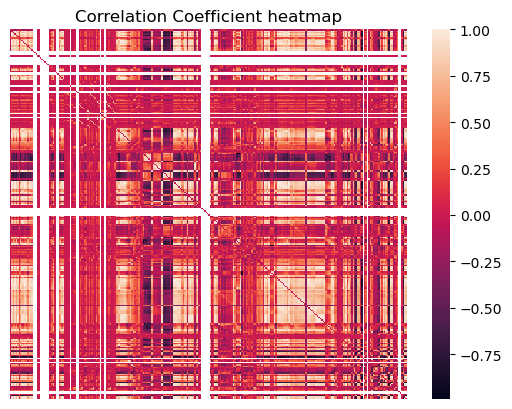

In [18]:
#join LOX and ANT to one matrix. Calculate correlation coefficient and drop columns
#with minimum threshold
corr_matrix = merged_train.corr() #correlation coefficient calculation
np.fill_diagonal(corr_matrix.values, 0) # set diagonal to 0
threshold = 0.9

ax = plt.axes()
sns.heatmap(corr_matrix, xticklabels=False, yticklabels=False)
ax.set_title('Correlation Coefficient heatmap')

corr_matrix = abs(corr_matrix) #absolute values of corr coef

corr_matrix = corr_matrix.replace(np.nan, 0) #replace nan with 0

corr_matrix.values[np.tril_indices(corr_matrix.shape[0], k=0)] = 0 #set values below diagonal to 0 so i dont drop both columns

drop_columns = corr_matrix.columns[corr_matrix.max() > threshold].tolist() #columns where corr coef > threshold
train_set = merged_train.drop(drop_columns, axis = 1) #drop above columns
df_test = df_test.drop(drop_columns, axis=1) #drop same columns from tests
print("Shape of train set after column drop",train_set.shape)
plt.savefig('../results/heatmap', dpi=500)

In [19]:
#normalization
scaler = preprocessing.MinMaxScaler()

cols = train_set.columns
d = scaler.fit_transform(train_set)
train_set = pd.DataFrame(d, columns=cols)

cols = df_test.columns
d = scaler.fit_transform(df_test)
df_test = pd.DataFrame(d, columns=cols)

In [20]:
#form data for tests
x = train_set.loc[:, train_set.columns != 'class']
y = train_set.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

In [21]:
#Calculate logistic regression with KFold cross validation

kfold = KFold(n_splits=5, random_state=0, shuffle=True)
lr_model = LogisticRegression(solver='liblinear', max_iter = 500)
results = cross_val_score(lr_model, x, y, cv=kfold)

print(results)

[0.92903226 0.93381759 0.937046   0.92736077 0.93058918]


In [22]:
#Create a svm Classifier
svm_model = svm.SVC(random_state=1, probability=True)

svm_model.fit(x_train, y_train)

results = cross_val_score(svm_model, x, y, cv=kfold)

print(results)

[0.94354839 0.95722357 0.94188862 0.94673123 0.94108152]


In [23]:
#Decision Tree Classifier

dtc_model = DecisionTreeClassifier(max_depth=10, random_state=0)
dtc_model.fit(x,y)
cross_val_score(dtc_model, x, y, cv=5)

array([0.95080645, 0.86844229, 0.84342211, 0.78692494, 0.66505246])

In [24]:
#Random Forest Classifier

rfc_model = RandomForestClassifier(max_depth=10, random_state=0)
rfc_model.fit(x, y)
cross_val_score(rfc_model, x, y, cv=5)

array([0.92580645, 0.92090395, 0.88861985, 0.84503632, 0.97497982])

In [25]:
#LightGBM

lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
lgb_model.fit(x_train.to_numpy(),y_train.to_numpy(),eval_set=[(x_test.to_numpy(),y_test.to_numpy()),(x_train.to_numpy(),y_train.to_numpy())],verbose=20,eval_metric='logloss')

[20]	valid_0's binary_logloss: 0.10128	valid_1's binary_logloss: 0.0665599
[40]	valid_0's binary_logloss: 0.0524682	valid_1's binary_logloss: 0.0201099
[60]	valid_0's binary_logloss: 0.0360283	valid_1's binary_logloss: 0.00748211
[80]	valid_0's binary_logloss: 0.0309645	valid_1's binary_logloss: 0.00345506
[100]	valid_0's binary_logloss: 0.0311242	valid_1's binary_logloss: 0.00214314


c:\Users\ste13\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [26]:
print('LightGBM results:')
print(f'Training accuracy {lgb_model.score(x_train,y_train):.5f}')
print(f'Testing accuracy {lgb_model.score(x_test,y_test):.5f}')

LightGBM results:
Training accuracy 0.99928
Testing accuracy 0.99194


In [27]:
lgb_model.predict_proba(df_test)

array([[0.50476559, 0.49523441],
       [0.02944418, 0.97055582],
       [0.41570219, 0.58429781],
       [0.12105705, 0.87894295],
       [0.02484958, 0.97515042],
       [0.02323816, 0.97676184],
       [0.99869143, 0.00130857],
       [0.9982738 , 0.0017262 ],
       [0.99615479, 0.00384521],
       [0.99447374, 0.00552626],
       [0.99460583, 0.00539417],
       [0.99550606, 0.00449394],
       [0.98303262, 0.01696738],
       [0.03402708, 0.96597292],
       [0.05347449, 0.94652551],
       [0.115406  , 0.884594  ],
       [0.40877661, 0.59122339],
       [0.68370677, 0.31629323],
       [0.07838865, 0.92161135],
       [0.08462937, 0.91537063],
       [0.08462937, 0.91537063],
       [0.08468354, 0.91531646],
       [0.14462697, 0.85537303],
       [0.27499518, 0.72500482]])